In [1]:
#**** Sentiment Analysis using Dutch Tweets****
# by SELIM SAMETOGLU
# This is a secondary version where I try to implement pipelines from scikitlearn


In [2]:
# to connect to drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# load the dependencies
# Utility
import pandas as pd
import numpy as np
import re
# Prepro
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
# Plotting
from matplotlib import pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

In [4]:
# Load the dataset
data = pd.read_json("/content/drive/MyDrive/Collab_data/dutch_tweets_chunk0.json")

In [5]:
# Check the lenght of the data
print('number of messages:', len(data))

number of messages: 27019


In [6]:
# data[["sentiment_pattern"]].hist()

In [161]:
# data[["sentiment_pattern"]]

array([[<Axes: title={'center': 'sentiment_pattern'}>]], dtype=object)

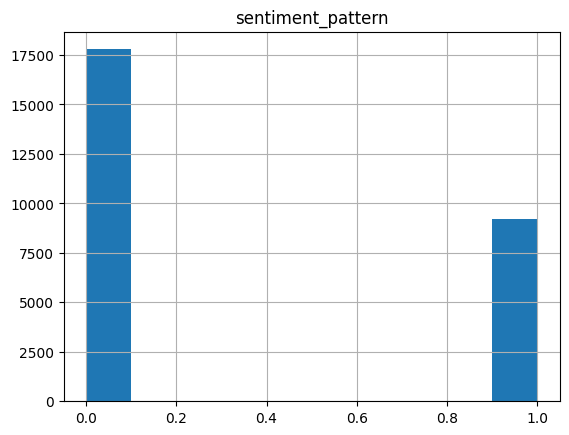

In [7]:
data.loc[data["sentiment_pattern"] <0, "sentiment_pattern"] = 0
data.loc[data["sentiment_pattern"] >0, "sentiment_pattern"] = 1
data[["sentiment_pattern"]].hist()


In [8]:
# take only a small portion for better speed
data = data[:1500]

In [10]:
# filter out non-Dutch sentences
# !pip install langdetect

from langdetect import detect

def detect_language(text):
    try:
        return detect(text)
    except:
        return 'unknown'

data['language']=data['full_text'].apply(detect_language)




     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 12.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993224 sha256=9609ecc0ed14e7806a36b66e7547a8c9f7bf111663fb3c1bc8d786f988bbd9a2
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect


In [11]:
data = data[data['language'] == 'nl']

In [12]:
data.drop('language', axis = 1, inplace = True)

In [13]:
data.head()

,full_text,text_translation,created_at,screen_name,description,desc_translation,weekofyear,weekday,day,month,...,point,latitude,longitude,altitude,province,hisco_standard,hisco_code,industry,sentiment_pattern,subjective_pattern
2,RT @DDStandaard: De droom van D66 wordt werkel...,RT @DDStandaard: The D66 dream come true: COVI...,2020-03-09 12:26:37,EricL65,None,None,11,0,9,3,...,None,NaN,NaN,0.0,False,None,None,False,0.0,0.00
3,RT @DDStandaard: De droom van D66 wordt werkel...,RT @DDStandaard: The D66 dream come true: COVI...,2020-03-09 12:26:37,EricL65,None,None,11,0,9,3,...,None,NaN,NaN,0.0,False,None,None,False,0.0,0.00
4,De droom van D66 wordt werkelijkheid: COVID-19...,The D66 dream becomes reality: COVID-19 super ...,2020-03-09 12:26:47,EhrErwin,Budget-Life Coach. Time management Coaching. b...,Budget-Life Coach. Time management coaching. h...,11,0,9,3,...,"(52.3727598, 4.8936041, 0.0)",52.37276,4.893604,0.0,Noord-Holland,None,None,False,0.0,0.00
5,De droom van D66 wordt werkelijkheid: COVID-19...,The D66 dream becomes reality: COVID-19 super ...,2020-03-09 12:26:47,EhrErwin,Budget-Life Coach. Time management Coaching. b...,Budget-Life Coach. Time management coaching. h...,11,0,9,3,...,"(52.3727598, 4.8936041, 0.0)",52.37276,4.893604,0.0,Noord-Holland,None,None,False,0.0,0.00
9,RT @FrankvanWijck: Het aantal deskundigen over...,RT @FrankvanWijck: The number of experts on co...,2020-03-09 12:27:35,martijnmollers,Chirurg @ Heelkunde Friesland | Auteur Hart en...,Surgeon @ Surgery Friesland | Author Heart and...,11,0,9,3,...,None,NaN,NaN,0.0,False,None,None,False,1.0,0.75


In [14]:
data = data[["full_text", "sentiment_pattern"]]

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
train_data, test_data = train_test_split(data, test_size = 0.2, random_state = 42)

In [17]:
# checking null values
np.sum(data.isnull().any(axis=1))

0

In [18]:
data.columns = ["text", "label"]

In [19]:
# make the statement text in lowercase
data['text']=data['text'].str.lower()

In [20]:
data['text'].tail()

1493    rt @ojongere: 😰😰😰😰🤬🤬🤬🤬🤬\ncorona blijkt stuk ha...
1494    waalse ps-minister: “belgië is een gecomplicee...
1495    corona in drenthe en groningen | de jacht op d...
1496    rt @bos_m: jaap van dissel, rivm: 'ook nieuw o...
1499    rt @_sbp99: ik ga niet liegen deze lockdown ha...
Name: text, dtype: object

In [21]:
# define the DUTCH stopwordlist
stopwordlist = ['aan',
'al',
'alles',
'als',
'altijd',
'andere',
'ben',
'bij',
'daar',
'dan',
'dat',
'de',
'der',
'deze',
'die',
'dit',
'doch',
'doen',
'door',
'dus',
'een',
'eens',
'en',
'er',
'ge',
'geen',
'geweest',
'haar',
'had',
'heb',
'hebben',
'heeft',
'hem',
'het',
'hier',
'hij',
'hoe',
'hun',
'iemand',
'iets',
'ik',
'in',
'is',
'ja',
'je',
'kan',
'kon',
'kunnen',
'maar',
'me',
'meer',
'men',
'met',
'mij',
'mijn',
'moet',
'na',
'naar',
'niet',
'niets',
'nog',
'nu',
'of',
'om',
'omdat',
'onder',
'ons',
'ook',
'op',
'over',
'reeds',
'te',
'tegen',
'toch',
'toen',
'tot',
'u',
'uit',
'uw',
'van',
'veel',
'voor',
'want',
'waren',
'was',
'wat',
'werd',
'wezen',
'wie',
'wil',
'worden',
'wordt',
'zal',
'ze',
'zelf',
'zich',
'zij',
'zijn',
'zo',
'zonder',
'zou']


In [22]:
# clean and remove the stopwords from the text
STOPWORDS = set(stopwordlist)
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

data['text'] = data['text'].apply(lambda text: cleaning_stopwords(text))
data['text'].head()

2    rt @ddstandaard: droom d66 werkelijkheid: covi...
3    rt @ddstandaard: droom d66 werkelijkheid: covi...
4    droom d66 werkelijkheid: covid-19 superdodelij...
5    droom d66 werkelijkheid: covid-19 superdodelij...
9    rt @frankvanwijck: aantal deskundigen corona g...
Name: text, dtype: object

In [23]:
# clean and remove the punctuations
import string
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)
data['text']= data['text'].apply(lambda x: cleaning_punctuations(x))
data['text'].tail()

1493    rt ojongere 😰😰😰😰🤬🤬🤬🤬🤬 corona blijkt stuk harde...
1494    waalse psminister “belgië gecompliceerd land p...
1495    corona drenthe groningen  jacht mondkapjes gaa...
1496    rt bosm jaap dissel rivm ook nieuw onderzoek s...
1499            rt sbp99 ga liegen lockdown wel voordelen
Name: text, dtype: object

In [24]:
# clean and remove repeating characters
def cleaning_repeating_char(text):
    return re.sub(r'(.)1+', r'1', text)
data['text'] = data['text'].apply(lambda x: cleaning_repeating_char(x))
data['text'].tail()

1493    rt ojongere 😰😰😰😰🤬🤬🤬🤬🤬 corona blijkt stuk harde...
1494    waalse psminister “belgië gecompliceerd land p...
1495    corona drenthe groningen  jacht mondkapjes gaa...
1496    rt bosm jaap dissel rivm ook nieuw onderzoek s...
1499            rt sbp99 ga liegen lockdown wel voordelen
Name: text, dtype: object

In [25]:
# clean and remove URLs
def cleaning_URLs(dataset):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ', dataset)
data['text'] = data['text'].apply(lambda x: cleaning_URLs(x))
data['text'].tail()

1493    rt ojongere 😰😰😰😰🤬🤬🤬🤬🤬 corona blijkt stuk harde...
1494    waalse psminister “belgië gecompliceerd land p...
1495    corona drenthe groningen  jacht mondkapjes gaa...
1496    rt bosm jaap dissel rivm ook nieuw onderzoek s...
1499            rt sbp99 ga liegen lockdown wel voordelen
Name: text, dtype: object

In [26]:
# clean and remove numbers
def cleaning_numbers(dataset):
    return re.sub('[0-9]+', '', dataset)
data['text'] = data['text'].apply(lambda x: cleaning_numbers(x))
data['text'].tail()

1493    rt ojongere 😰😰😰😰🤬🤬🤬🤬🤬 corona blijkt stuk harde...
1494    waalse psminister “belgië gecompliceerd land p...
1495    corona drenthe groningen  jacht mondkapjes gaa...
1496    rt bosm jaap dissel rivm ook nieuw onderzoek s...
1499              rt sbp ga liegen lockdown wel voordelen
Name: text, dtype: object

In [27]:
data['text']

2       rt ddstandaard droom d werkelijkheid covi supe...
3       rt ddstandaard droom d werkelijkheid covi supe...
4       droom d werkelijkheid covi superdodelijk ouder...
5       droom d werkelijkheid covi superdodelijk ouder...
9       rt frankvanwijck aantal deskundigen corona gri...
                              ...                        
1493    rt ojongere 😰😰😰😰🤬🤬🤬🤬🤬 corona blijkt stuk harde...
1494    waalse psminister “belgië gecompliceerd land p...
1495    corona drenthe groningen  jacht mondkapjes gaa...
1496    rt bosm jaap dissel rivm ook nieuw onderzoek s...
1499              rt sbp ga liegen lockdown wel voordelen
Name: text, Length: 1182, dtype: object

In [28]:
# tokenization
from nltk.tokenize import TreebankWordTokenizer
tokenizer = TreebankWordTokenizer()
data['text'] = data['text'].apply(tokenizer.tokenize)
data['text']

2       [rt, ddstandaard, droom, d, werkelijkheid, cov...
3       [rt, ddstandaard, droom, d, werkelijkheid, cov...
4       [droom, d, werkelijkheid, covi, superdodelijk,...
5       [droom, d, werkelijkheid, covi, superdodelijk,...
9       [rt, frankvanwijck, aantal, deskundigen, coron...
                              ...                        
1493    [rt, ojongere, 😰😰😰😰🤬🤬🤬🤬🤬, corona, blijkt, stuk...
1494    [waalse, psminister, “belgië, gecompliceerd, l...
1495    [corona, drenthe, groningen, jacht, mondkapjes...
1496    [rt, bosm, jaap, dissel, rivm, ook, nieuw, ond...
1499      [rt, sbp, ga, liegen, lockdown, wel, voordelen]
Name: text, Length: 1182, dtype: object

In [29]:
# stemming
from nltk.stem.snowball import DutchStemmer

st = DutchStemmer()
def stemming_on_text(dataset):
    text = [st.stem(word) for word in dataset]
    return dataset
data['text']= data['text'].apply(lambda x: stemming_on_text(x))
data['text'].head()

2    [rt, ddstandaard, droom, d, werkelijkheid, cov...
3    [rt, ddstandaard, droom, d, werkelijkheid, cov...
4    [droom, d, werkelijkheid, covi, superdodelijk,...
5    [droom, d, werkelijkheid, covi, superdodelijk,...
9    [rt, frankvanwijck, aantal, deskundigen, coron...
Name: text, dtype: object

In [30]:
# create the 'X' with the features, and create the'y' with the annotations/sentiment
X = data['text']
y = data['label']

In [31]:
data_pos = data.loc[data['label'] == 1]
data_neg = data.loc[data['label'] == 0]
data_pos = data_pos['text']
data_neg = data_neg['text']

In [32]:
data_neg

2       [rt, ddstandaard, droom, d, werkelijkheid, cov...
3       [rt, ddstandaard, droom, d, werkelijkheid, cov...
4       [droom, d, werkelijkheid, covi, superdodelijk,...
5       [droom, d, werkelijkheid, covi, superdodelijk,...
12      [dommer, dommer, we, weten, alleen, ca, bevest...
                              ...                        
1488    [rt, adnl, corona, blijkt, stuk, harder, toe, ...
1491    [lockdownmaatregelen, verspreiding, covi, gaan...
1492    [rt, ojongere, 😰😰😰😰🤬🤬🤬🤬🤬, corona, blijkt, stuk...
1493    [rt, ojongere, 😰😰😰😰🤬🤬🤬🤬🤬, corona, blijkt, stuk...
1494    [waalse, psminister, “belgië, gecompliceerd, l...
Name: text, Length: 689, dtype: object

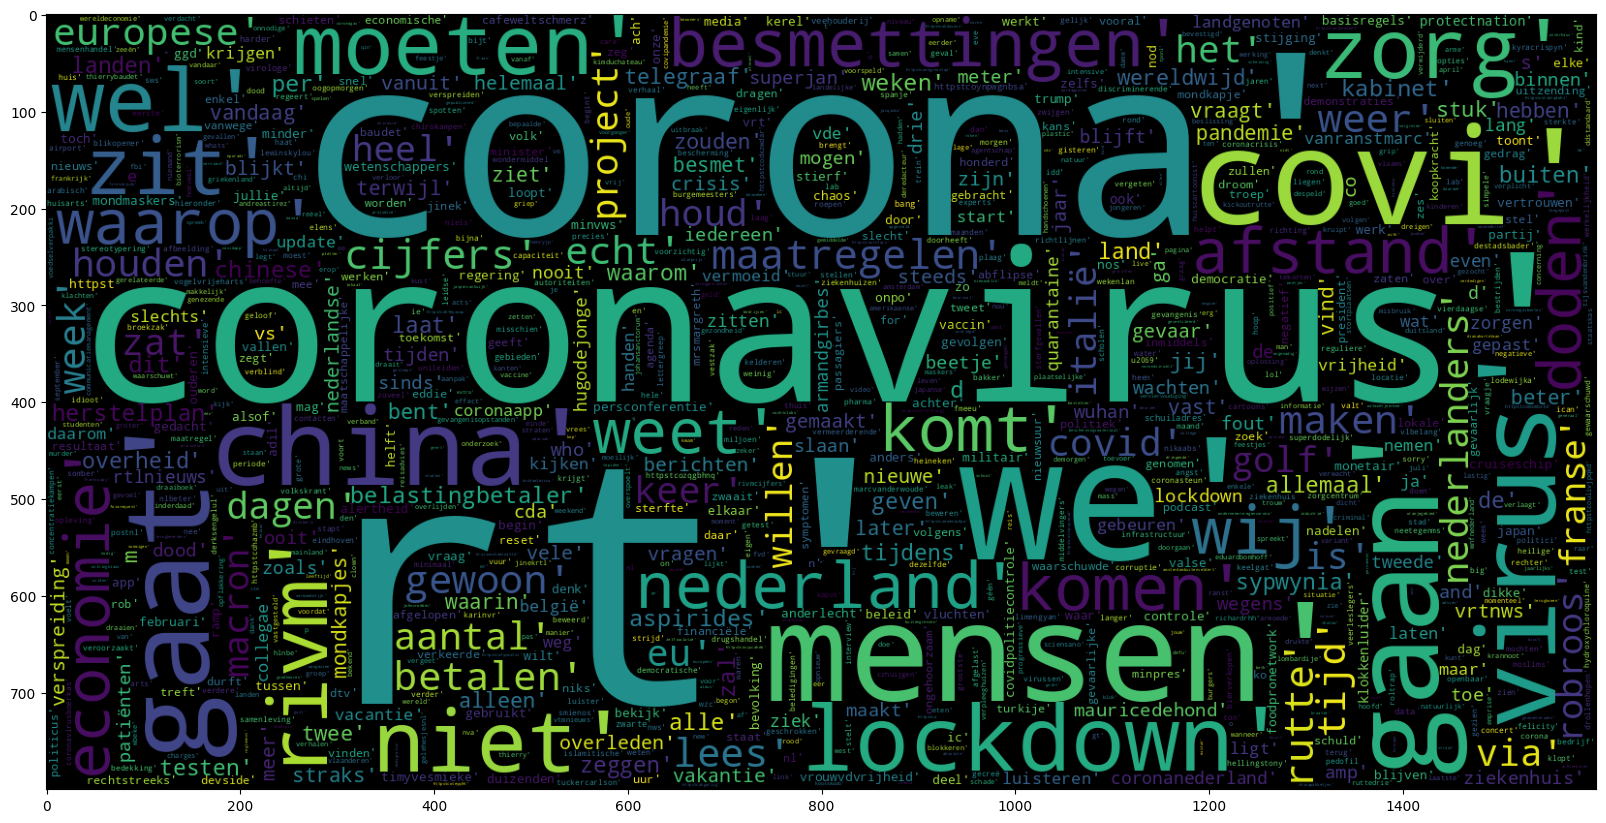

In [33]:
#data_neg = data_neg[:9230]
plt.figure(figsize = (20,20))
wc_neg = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(map(str, data_neg)))
plt.imshow(wc_neg)


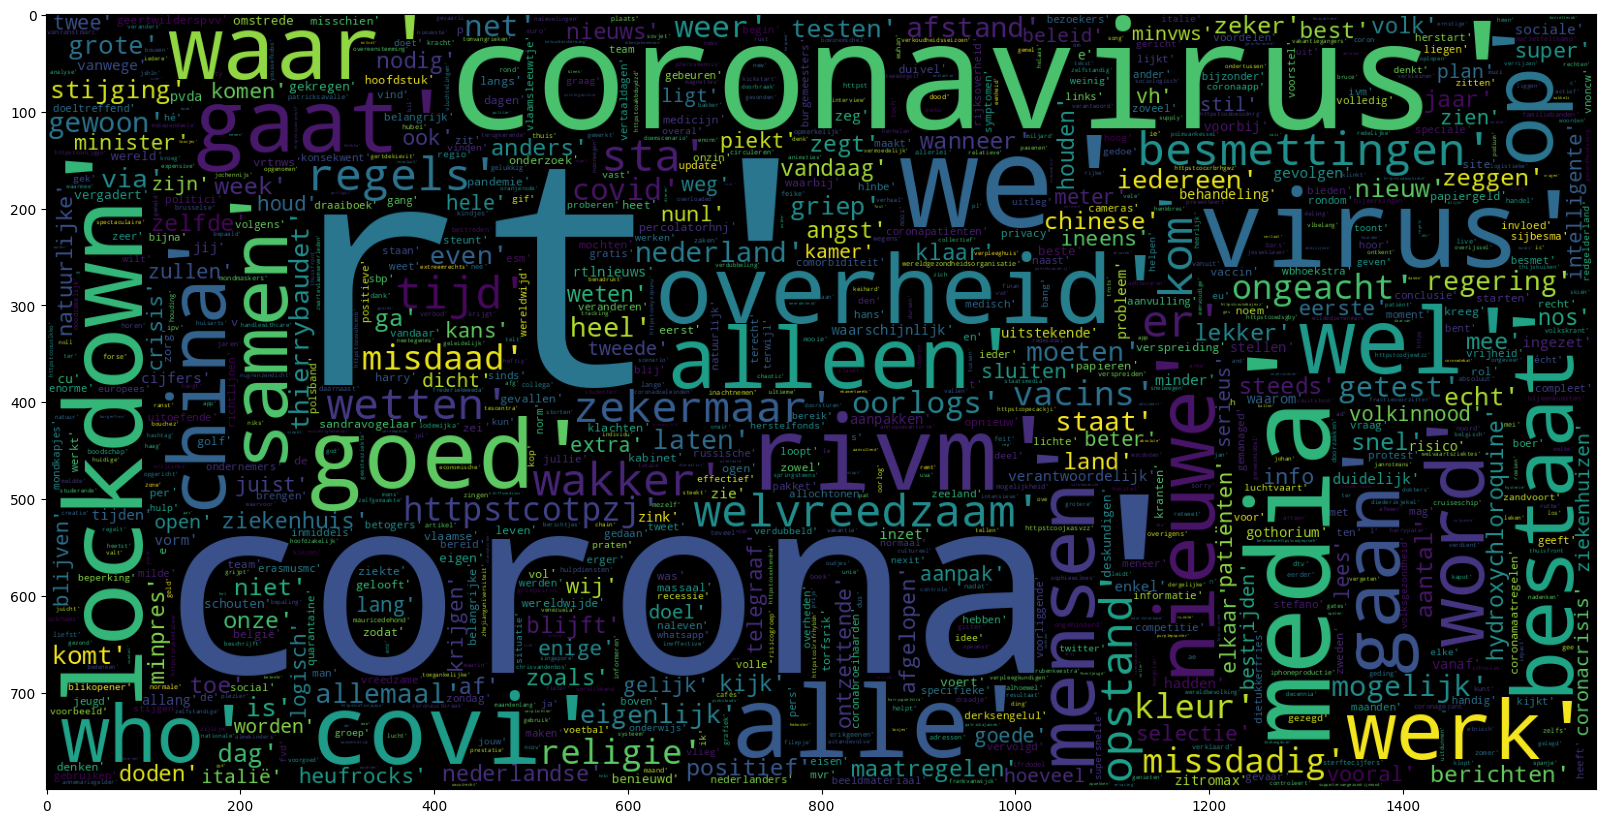

In [34]:
# data_pos = data_pos[:17789]
plt.figure(figsize = (20,20))
wc_pos = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(map(str, data_pos)))
plt.imshow(wc_pos)


In [35]:
# split the data into train and test subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.05, random_state = 42)

In [36]:
X_train = X_train.astype(str)
X_test = X_test.astype(str)

In [37]:
# FIT THE TF-IDF VECTORIZER BASED ON THE TRAIN DATA
vectoriser = TfidfVectorizer(ngram_range=(1, 2), max_features = 500000)
vectoriser.fit(X_train)

TfidfVectorizer(max_features=500000, ngram_range=(1, 2))

In [39]:
print('No. of feature_words: ', len(vectoriser.get_feature_names_out()))

No. of feature_words:  13385


In [40]:
# TRANSFORM THE DATA USING TF-IDF VECTORIZER; TRANSFORM BOTH TRAIN AND THE TEST DATA
X_train = vectoriser.transform(X_train)
X_test = vectoriser.transform(X_test)

In [41]:
# NICE WRAPPED UP MODEL EVALUATION FUNCTION. REAUSABLE.
# creds to https://www.analyticsvidhya.com/blog/2021/06/twitter-sentiment-analysis-a-nlp-use-case-for-beginners/
def model_Evaluate(model):
    # Predict values for Test dataset
    y_pred = model.predict(X_test)
    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)
    categories = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
    xticklabels = categories, yticklabels = categories)
    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

              precision    recall  f1-score   support

         0.0       0.79      1.00      0.89        31
         1.0       1.00      0.72      0.84        29

    accuracy                           0.87        60
   macro avg       0.90      0.86      0.86        60
weighted avg       0.89      0.87      0.86        60



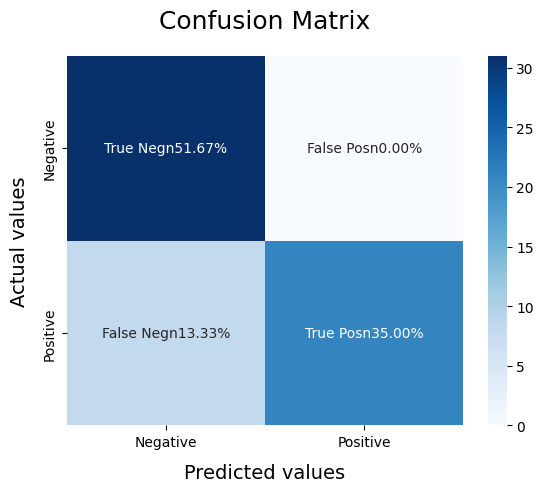

In [42]:
BNBmodel = BernoulliNB()
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)
y_pred1 = BNBmodel.predict(X_test)

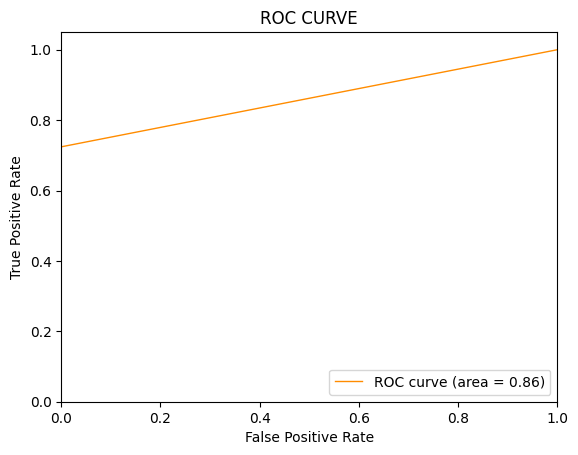

In [43]:
# SAME AS ABOVE, NICE WRAPPER, this time for the ROC CURVE:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred1)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

              precision    recall  f1-score   support

         0.0       0.85      0.94      0.89        31
         1.0       0.92      0.83      0.87        29

    accuracy                           0.88        60
   macro avg       0.89      0.88      0.88        60
weighted avg       0.89      0.88      0.88        60



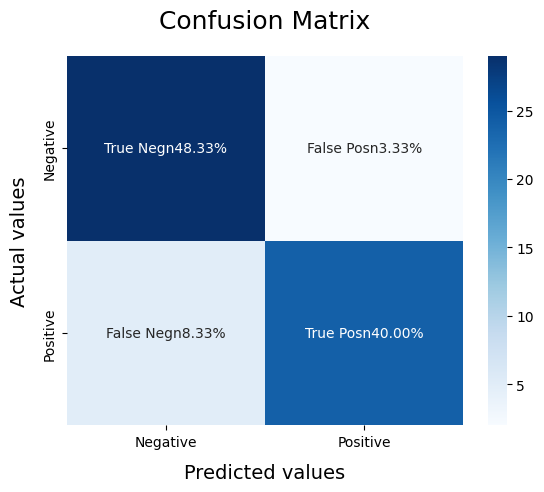

In [44]:
# MODEL - 2
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)
y_pred2 = SVCmodel.predict(X_test)

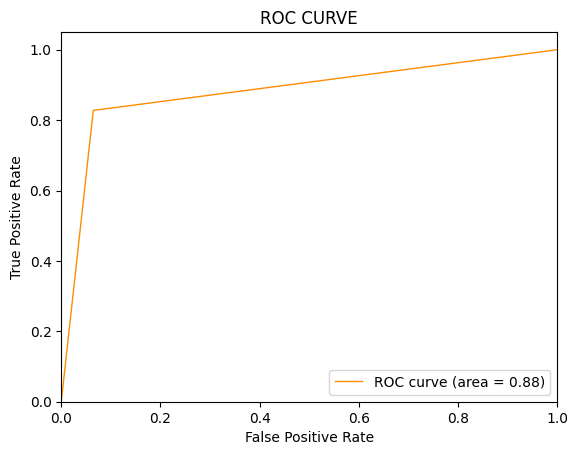

In [45]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred2)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

              precision    recall  f1-score   support

         0.0       0.83      0.97      0.90        31
         1.0       0.96      0.79      0.87        29

    accuracy                           0.88        60
   macro avg       0.90      0.88      0.88        60
weighted avg       0.89      0.88      0.88        60



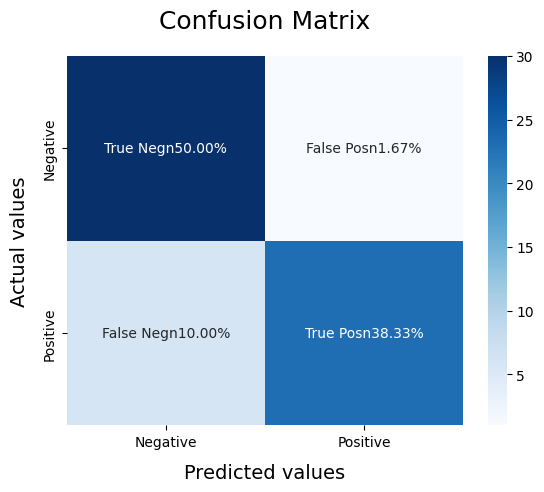

In [46]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)
y_pred3 = LRmodel.predict(X_test)

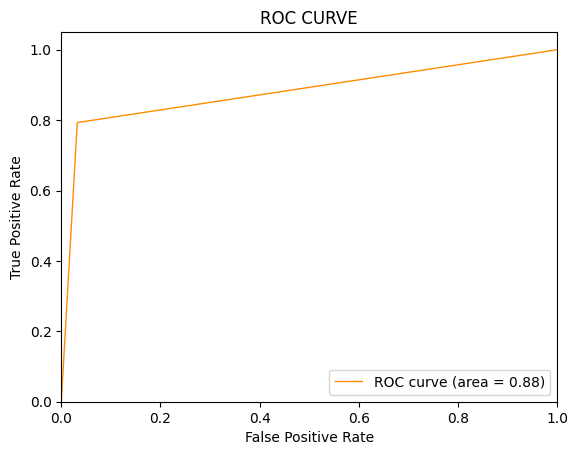

In [47]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred3)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

In [48]:
# result: linear support vector classifier (svc) worked the best


In [51]:
#  Creating a column selector (custom transformer)


from sklearn.base import BaseEstimator, TransformerMixin

class TextSelector(BaseEstimator, TransformerMixin):
  def __init__(self, key):
    self.key = key

  def fit(self, X, y=None):
    return self

  def transform(self, X, y =None):
    return X[self.key]

class NumberSelector(BaseEstimator, TransformerMixin):
  def __init__(self, key):
    self.key = key

  def fit(self, X, y = None):
    return self

  def transform(self, X, y =None):
    return X[[self.key]]
